In [2]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   'images/Training',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   'images/Testing',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   'images/Validation',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 3251 files belonging to 3 classes.
Found 405 files belonging to 3 classes.
Found 416 files belonging to 3 classes.


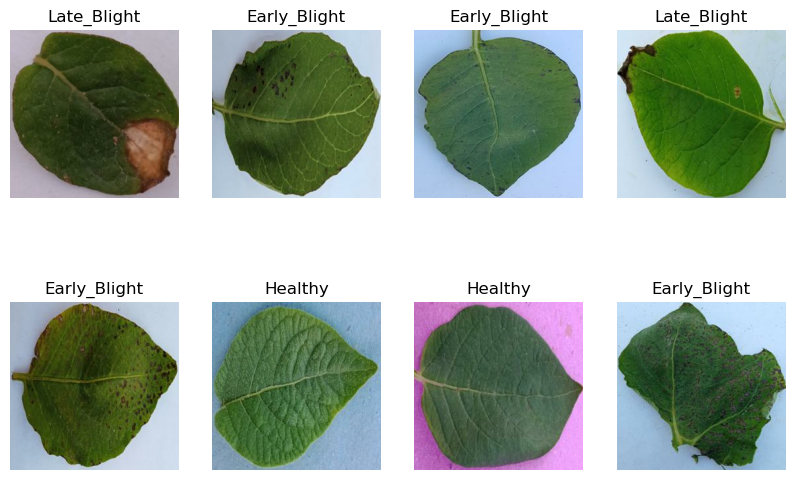

In [4]:
class_names = training_dataset.class_names

plt.figure(figsize=(10,10))
for image_batch,label_batch in training_dataset.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [5]:

data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Training dataset with data augmentation
train_data_gen = data_augmentation.flow_from_directory(
    directory='images/Training',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Use only the training samples
)


Found 3251 images belonging to 3 classes.


In [6]:
x_val_data = list()
y_val_data = list()
for image_batch, label_batch in validation_dataset:
    x_val_data.append(image_batch[0].numpy())
    y_val_data.append(label_batch[0].numpy())

# Convertir listas a matrices NumPy
val_images = np.array(x_val_data)
Y_val = np.array(y_val_data)


# Normalizamos las imágenes
X_val = val_images.astype('uint32') / 255

label_encoder = LabelEncoder()

encoded_val_labels = label_encoder.fit_transform(Y_val)
Y_val = np_utils.to_categorical(encoded_val_labels, 3)

x_training_data = list()
y_training_data = list()
for image_batch, label_batch in testing_dataset:
    x_training_data.append(image_batch[0].numpy())
    y_training_data.append(label_batch[0].numpy())

# Convertir listas a matrices NumPy
training_images = np.array(x_training_data)
Y_training = np.array(y_training_data)

# Normalizamos las imágenes
X_training = training_images.astype('uint32') / 255

encoded_training_labels = label_encoder.fit_transform(Y_training)
Y_training = np_utils.to_categorical(encoded_training_labels, 3)


In [23]:
model = Sequential()

# 1st CNN layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd CNN layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd CNN layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th CNN layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(len(class_names), activation='softmax'))


In [24]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)      

                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 4,325,507
Trainable params: 4,325,251
Non-trainable params: 256
_________________________________________________________________


In [36]:
batch_size=64
epochs=3

history = model.fit(train_data_gen,
                    epochs=epochs,  
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    shuffle=True,
                    verbose=1)

Epoch 1/3
102/102 [==============================] - 136s 1s/step - loss: 0.6107 - accuracy: 0.7518 - val_loss: 0.9240 - val_accuracy: 0.6923
Epoch 2/3
102/102 [==============================] - 141s 1s/step - loss: 0.5334 - accuracy: 0.7875 - val_loss: 0.7855 - val_accuracy: 0.8462
Epoch 3/3
102/102 [==============================] - 144s 1s/step - loss: 0.4654 - accuracy: 0.8271 - val_loss: 0.6739 - val_accuracy: 0.7692


Test loss: 0.6610084772109985
Test accuracy: 0.692307710647583
[0.7517687082290649, 0.7874500155448914, 0.827130138874054] [0.692307710647583, 0.8461538553237915, 0.7692307829856873]


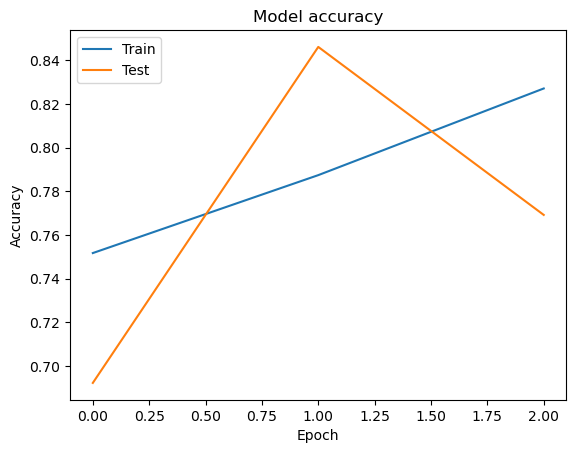

In [37]:
score = model.evaluate(X_training, Y_training, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values
print(history.history['accuracy'], history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The Image Title :  Early_Blight
1/1 [==============================] - 0s 289ms/step
Model Predicted label :  Early_Blight
The Image Title :  Late_Blight
1/1 [==============================] - 0s 284ms/step
Model Predicted label :  Late_Blight
The Image Title :  Healthy
1/1 [==============================] - 0s 288ms/step
Model Predicted label :  Late_Blight
The Image Title :  Early_Blight
1/1 [==============================] - 0s 301ms/step
Model Predicted label :  Early_Blight
The Image Title :  Healthy
1/1 [==============================] - 0s 299ms/step
Model Predicted label :  Early_Blight


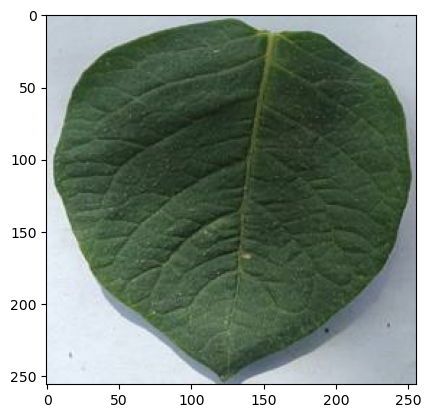

In [38]:
for image_batch, label_batch in testing_dataset.take(5):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print("The Image Title : ",class_names[label_batch[0].numpy()])
    prediction = model.predict(image_batch)
    print("Model Predicted label : ",class_names[np.argmax(prediction[0])])